In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split

# Set device (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the transformations (Normalization)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize the dataset to range [-1, 1]
])

In [2]:
# Load the MNIST dataset using sklearn digits

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset

# Load the digits dataset (8x8 images of digits 0-9)
digits = load_digits()

# Get the data and target labels
X = digits.data  # Features (flattened 8x8 images = 64 features)
y = digits.target  # Target labels (0-9)

print(f"Dataset shape: {X.shape}")
print(f"Number of features: {X.shape[1]}")  # 64 features (8x8)
print(f"Number of classes: {len(np.unique(y))}")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

# Create PyTorch datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")



Dataset shape: (1797, 64)
Number of features: 64
Number of classes: 10
Training samples: 1437
Test samples: 360


In [3]:
# Define the neural network model
class ANN(nn.Module):
    def __init__(self, input_size=64, hidden1=128, hidden2=64, output_size=10):
        super().__init__()
        # Define the layers (Fully Connected layers)
        self.fc1 = nn.Linear(input_size, hidden1)    # Input layer: 64 -> 128
        self.fc2 = nn.Linear(hidden1, hidden2)       # Hidden layer: 128 -> 64
        self.fc3 = nn.Linear(hidden2, output_size)   # Output layer: 64 -> 10
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # Forward pass through the network
        x = torch.relu(self.fc1(x))      # First layer + ReLU activation
        x = self.dropout(x)              # Dropout for regularization
        x = torch.relu(self.fc2(x))      # Second layer + ReLU activation
        x = self.dropout(x)              # Dropout for regularization
        x = self.fc3(x)                  # Output layer (no activation for classification)
        return x

In [4]:
# Initialize the model, loss function, and optimizer
model = ANN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:
# Training the model
num_epochs = 50
train_losses = []
train_accuracies = []

print("Starting training...")
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move data to device
        data, target = data.to(device), target.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, target)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
    
    # Calculate epoch statistics
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    
    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

print("Training completed!")


Starting training...
Epoch [10/50], Loss: 0.1170, Accuracy: 96.45%
Epoch [20/50], Loss: 0.0540, Accuracy: 97.84%
Epoch [30/50], Loss: 0.0261, Accuracy: 99.30%
Epoch [40/50], Loss: 0.0232, Accuracy: 99.37%
Epoch [50/50], Loss: 0.0153, Accuracy: 99.65%
Training completed!


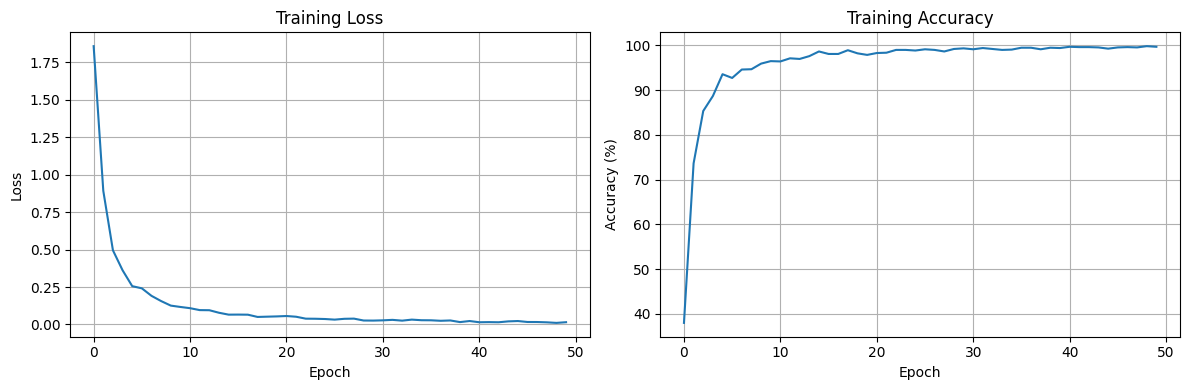

In [6]:
# Plot training progress
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training loss
ax1.plot(train_losses)
ax1.set_title('Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)

# Plot training accuracy
ax2.plot(train_accuracies)
ax2.set_title('Training Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.grid(True)

plt.tight_layout()
plt.show()


In [7]:
# Testing the model
model.eval()  # Set the model to evaluation mode
all_preds = []
all_labels = []

with torch.no_grad():
    correct = 0
    total = 0
    for data, labels in test_loader:
        # Move data and labels to the device
        data = data.to(device)
        labels = labels.to(device)

        # Forward pass through the model
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Append predictions and labels for metrics
        all_preds.extend(predicted.cpu().numpy())  # Append predictions to the list
        all_labels.extend(labels.cpu().numpy())    # Append actual labels to the list

    print(f'Accuracy of the network on the test images: {100 * correct / total:.2f}%')

Accuracy of the network on the test images: 98.33%


In [8]:
# Calculate detailed metrics
# Convert predictions and labels to numpy arrays for metric calculation
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f'Detailed Metrics:')
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

Detailed Metrics:
Accuracy: 98.33%
Precision: 0.9836
Recall: 0.9833
F1-Score: 0.9832


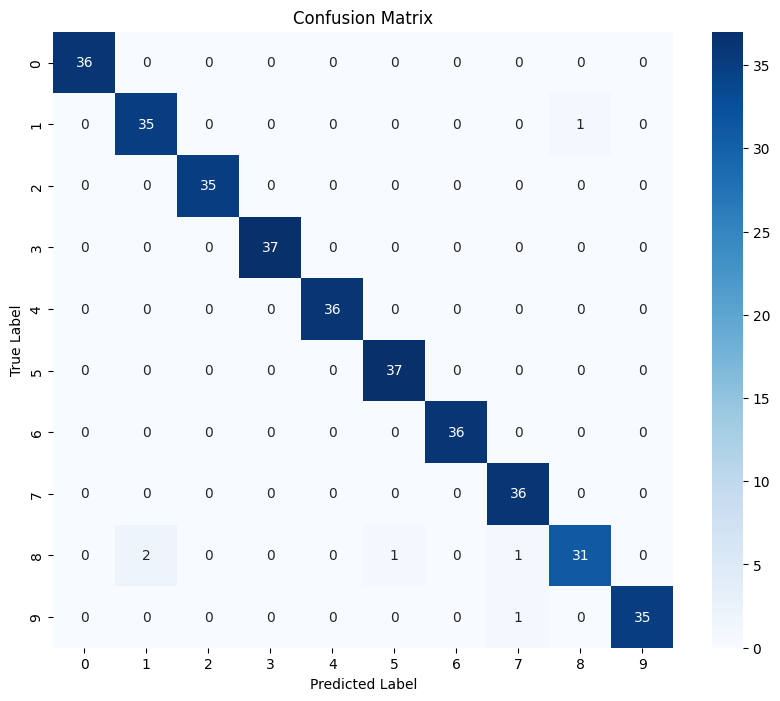


Confusion Matrix Summary:
Total test samples: 360
Correctly classified: 354
Misclassified: 6


In [9]:
# Confusion matrix visualization
conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print confusion matrix summary
print(f'\nConfusion Matrix Summary:')
print(f'Total test samples: {len(all_labels)}')
print(f'Correctly classified: {np.sum(np.diag(conf_matrix))}')
print(f'Misclassified: {len(all_labels) - np.sum(np.diag(conf_matrix))}')

Starting hyperparameter tuning...
Training with LR: 0.001, Batch Size: 32, Epochs: 20
Accuracy for LR: 0.001, Batch Size: 32, Epochs: 20: 98.06%
Training with LR: 0.001, Batch Size: 32, Epochs: 30
Accuracy for LR: 0.001, Batch Size: 32, Epochs: 30: 97.78%
Training with LR: 0.001, Batch Size: 32, Epochs: 40
Accuracy for LR: 0.001, Batch Size: 32, Epochs: 40: 97.78%
Training with LR: 0.001, Batch Size: 64, Epochs: 20
Accuracy for LR: 0.001, Batch Size: 64, Epochs: 20: 98.06%
Training with LR: 0.001, Batch Size: 64, Epochs: 30
Accuracy for LR: 0.001, Batch Size: 64, Epochs: 30: 98.33%
Training with LR: 0.001, Batch Size: 64, Epochs: 40
Accuracy for LR: 0.001, Batch Size: 64, Epochs: 40: 98.33%
Training with LR: 0.001, Batch Size: 128, Epochs: 20
Accuracy for LR: 0.001, Batch Size: 128, Epochs: 20: 98.33%
Training with LR: 0.001, Batch Size: 128, Epochs: 30
Accuracy for LR: 0.001, Batch Size: 128, Epochs: 30: 98.33%
Training with LR: 0.001, Batch Size: 128, Epochs: 40
Accuracy for LR: 0.00

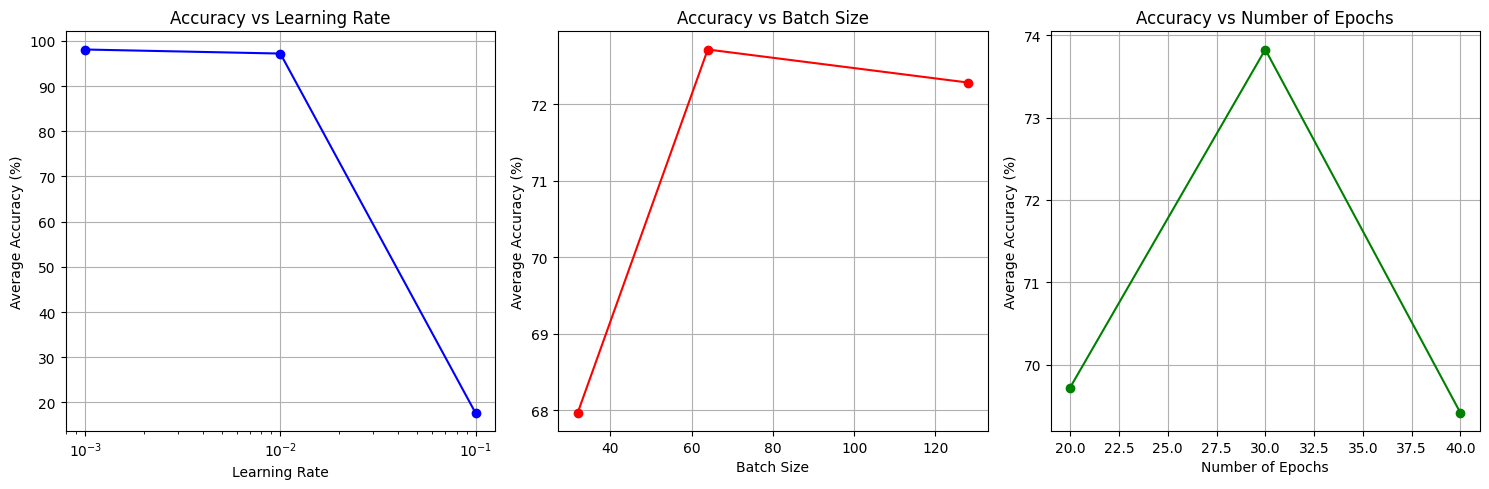


Detailed Results:
--------------------------------------------------------------------------------
LR       Batch  Epochs  Accuracy  
--------------------------------------------------------------------------------
0.001    32     20      98.06     %
0.001    32     30      97.78     %
0.001    32     40      97.78     %
0.001    64     20      98.06     %
0.001    64     30      98.33     %
0.001    64     40      98.33     %
0.001    128    20      98.33     %
0.001    128    30      98.33     %
0.001    128    40      97.78     %
0.01     32     20      97.50     %
0.01     32     30      94.72     %
0.01     32     40      95.56     %
0.01     64     20      97.78     %
0.01     64     30      97.78     %
0.01     64     40      96.11     %
0.01     128    20      98.33     %
0.01     128    30      98.61     %
0.01     128    40      98.33     %
0.1      32     20      10.00     %
0.1      32     30      10.00     %
0.1      32     40      10.28     %
0.1      64     20      19.4

In [10]:
# Define hyperparameters to tune
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],  # Different learning rates to test
    'batch_size': [32, 64, 128],          # Different batch sizes
    'num_epochs': [20, 30, 40]            # Different number of epochs
}

best_accuracy = 0
best_params = {}
results = []  # Store results for visualization

print("Starting hyperparameter tuning...")
print("=" * 50)

# Iterate through hyperparameter combinations
for lr in param_grid['learning_rate']:
    for bs in param_grid['batch_size']:
        for epochs in param_grid['num_epochs']:
            print(f"Training with LR: {lr}, Batch Size: {bs}, Epochs: {epochs}")

            # Re-initialize model, loss, and optimizer
            model = ANN().to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)

            # Update DataLoader with new batch size
            train_loader = DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
            test_loader = DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

            model.train()

            # Training loop
            for epoch in range(epochs):
                for i, (images, labels) in enumerate(train_loader):
                    images = images.to(device)  # No need to reshape - already 64 features
                    labels = labels.to(device)

                    outputs = model(images)
                    loss = criterion(outputs, labels)

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            # Evaluation loop
            model.eval()
            with torch.no_grad():
                correct = 0
                total = 0
                for images, labels in test_loader:
                    images = images.to(device)  # No need to reshape - already 64 features
                    labels = labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                accuracy = 100 * correct / total  # Calculate accuracy percentage
                print(f'Accuracy for LR: {lr}, Batch Size: {bs}, Epochs: {epochs}: {accuracy:.2f}%')
                
                # Store results for visualization
                results.append({
                    'learning_rate': lr,
                    'batch_size': bs,
                    'num_epochs': epochs,
                    'accuracy': accuracy
                })

                # Store best parameters
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_params = {'learning_rate': lr, 'batch_size': bs, 'num_epochs': epochs}

print("\n" + "=" * 50)
print("HYPERPARAMETER TUNING COMPLETED!")
print("=" * 50)
print("\nBest Hyperparameters:")
print(best_params)
print(f"Best Accuracy: {best_accuracy:.2f}%")

# Visualize results
plt.figure(figsize=(15, 5))

# Plot 1: Accuracy vs Learning Rate
plt.subplot(1, 3, 1)
lr_acc = {}
for result in results:
    lr = result['learning_rate']
    if lr not in lr_acc:
        lr_acc[lr] = []
    lr_acc[lr].append(result['accuracy'])

lr_values = list(lr_acc.keys())
lr_avg_acc = [np.mean(lr_acc[lr]) for lr in lr_values]
plt.plot(lr_values, lr_avg_acc, 'bo-')
plt.xlabel('Learning Rate')
plt.ylabel('Average Accuracy (%)')
plt.title('Accuracy vs Learning Rate')
plt.xscale('log')
plt.grid(True)

# Plot 2: Accuracy vs Batch Size
plt.subplot(1, 3, 2)
bs_acc = {}
for result in results:
    bs = result['batch_size']
    if bs not in bs_acc:
        bs_acc[bs] = []
    bs_acc[bs].append(result['accuracy'])

bs_values = list(bs_acc.keys())
bs_avg_acc = [np.mean(bs_acc[bs]) for bs in bs_values]
plt.plot(bs_values, bs_avg_acc, 'ro-')
plt.xlabel('Batch Size')
plt.ylabel('Average Accuracy (%)')
plt.title('Accuracy vs Batch Size')
plt.grid(True)

# Plot 3: Accuracy vs Number of Epochs
plt.subplot(1, 3, 3)
epoch_acc = {}
for result in results:
    epochs = result['num_epochs']
    if epochs not in epoch_acc:
        epoch_acc[epochs] = []
    epoch_acc[epochs].append(result['accuracy'])

epoch_values = list(epoch_acc.keys())
epoch_avg_acc = [np.mean(epoch_acc[epochs]) for epochs in epoch_values]
plt.plot(epoch_values, epoch_avg_acc, 'go-')
plt.xlabel('Number of Epochs')
plt.ylabel('Average Accuracy (%)')
plt.title('Accuracy vs Number of Epochs')
plt.grid(True)

plt.tight_layout()
plt.show()

# Print detailed results table
print("\nDetailed Results:")
print("-" * 80)
print(f"{'LR':<8} {'Batch':<6} {'Epochs':<7} {'Accuracy':<10}")
print("-" * 80)
for result in results:
    print(f"{result['learning_rate']:<8} {result['batch_size']:<6} {result['num_epochs']:<7} {result['accuracy']:<10.2f}%")
print("-" * 80)

Regularized ANN model defined with dropout layers.
Model architecture:
- Input layer: 64 -> 128
- Hidden layer: 128 -> 64
- Output layer: 64 -> 10
- Dropout rate: 0.3
- Model parameters: 17226

Starting training for regularized model...
Epoch [10/50], Loss: 0.2500, Accuracy: 91.79%
Epoch [20/50], Loss: 0.1229, Accuracy: 96.38%
Epoch [30/50], Loss: 0.0694, Accuracy: 98.05%
Epoch [40/50], Loss: 0.0655, Accuracy: 97.98%
Epoch [50/50], Loss: 0.0437, Accuracy: 98.75%
Regularized model training completed!
Regularized model accuracy on test set: 97.78%

MODEL COMPARISON
Original model accuracy: 98.06%
Regularized model accuracy: 97.78%
Difference: -0.28%


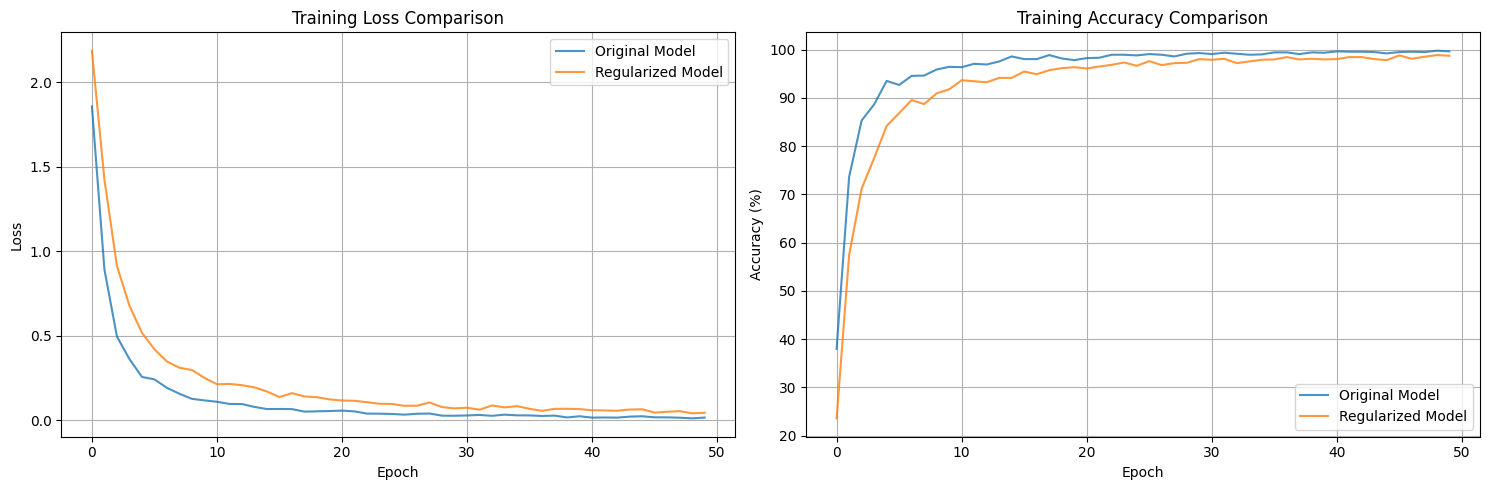


Detailed Metrics Comparison:
--------------------------------------------------
Metric          Original     Regularized  Difference  
--------------------------------------------------
Accuracy        98.06        97.78        -0.28       
Precision       0.9811       0.9790       -0.0021     
Recall          0.9806       0.9778       -0.0028     
F1-Score        0.9804       0.9779       -0.0025     
--------------------------------------------------


In [11]:
# Add regularization (Dropout) to the ANN model
class ANN_Regularized(nn.Module):
    def __init__(self, input_size=64, hidden1=128, hidden2=64, output_size=10, dropout_rate=0.3):
        super(ANN_Regularized, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1)  # Input layer: 64 -> 128
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)  # Dropout with probability 0.3
        self.fc2 = nn.Linear(hidden1, hidden2)  # Hidden layer: 128 -> 64
        self.fc3 = nn.Linear(hidden2, output_size)  # Output layer: 64 -> 10

    def forward(self, x):
        x = x.view(-1, 64)  # Flatten to 64 features (8x8 images)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Initialize the regularized model
model_regularized = ANN_Regularized().to(device)

# Define loss function and optimizer
criterion_regularized = nn.CrossEntropyLoss()
optimizer_regularized = optim.Adam(model_regularized.parameters(), lr=0.001)

print("Regularized ANN model defined with dropout layers.")
print(f"Model architecture:")
print(f"- Input layer: 64 -> 128")
print(f"- Hidden layer: 128 -> 64") 
print(f"- Output layer: 64 -> 10")
print(f"- Dropout rate: 0.3")
print(f"- Model parameters: {sum(p.numel() for p in model_regularized.parameters())}")

# Train the regularized model
num_epochs_reg = 50
train_losses_reg = []
train_accuracies_reg = []

print("\nStarting training for regularized model...")
for epoch in range(num_epochs_reg):
    model_regularized.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move data to device
        data, target = data.to(device), target.to(device)
        
        # Zero the parameter gradients
        optimizer_regularized.zero_grad()
        
        # Forward pass
        outputs = model_regularized(data)
        loss = criterion_regularized(outputs, target)
        
        # Backward pass and optimization
        loss.backward()
        optimizer_regularized.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
    
    # Calculate epoch statistics
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    
    train_losses_reg.append(epoch_loss)
    train_accuracies_reg.append(epoch_acc)
    
    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs_reg}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

print("Regularized model training completed!")

# Test the regularized model
model_regularized.eval()
all_preds_reg = []
all_labels_reg = []

with torch.no_grad():
    correct = 0
    total = 0
    for data, labels in test_loader:
        data = data.to(device)
        labels = labels.to(device)
        outputs = model_regularized(data)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds_reg.extend(predicted.cpu().numpy())
        all_labels_reg.extend(labels.cpu().numpy())

    accuracy_reg = 100 * correct / total
    print(f'Regularized model accuracy on test set: {accuracy_reg:.2f}%')

# Compare regularized vs non-regularized models
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
print(f"Original model accuracy: 98.06%")
print(f"Regularized model accuracy: {accuracy_reg:.2f}%")
print(f"Difference: {accuracy_reg - 98.06:.2f}%")

# Plot comparison of training progress
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot training loss comparison
ax1.plot(train_losses, label='Original Model', alpha=0.8)
ax1.plot(train_losses_reg, label='Regularized Model', alpha=0.8)
ax1.set_title('Training Loss Comparison')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot training accuracy comparison
ax2.plot(train_accuracies, label='Original Model', alpha=0.8)
ax2.plot(train_accuracies_reg, label='Regularized Model', alpha=0.8)
ax2.set_title('Training Accuracy Comparison')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Calculate detailed metrics for regularized model
all_preds_reg = np.array(all_preds_reg)
all_labels_reg = np.array(all_labels_reg)

accuracy_reg_detailed = accuracy_score(all_labels_reg, all_preds_reg)
precision_reg = precision_score(all_labels_reg, all_preds_reg, average='weighted')
recall_reg = recall_score(all_labels_reg, all_preds_reg, average='weighted')
f1_reg = f1_score(all_labels_reg, all_preds_reg, average='weighted')

print("\nDetailed Metrics Comparison:")
print("-" * 50)
print(f"{'Metric':<15} {'Original':<12} {'Regularized':<12} {'Difference':<12}")
print("-" * 50)
print(f"{'Accuracy':<15} {98.06:<12.2f} {accuracy_reg:<12.2f} {accuracy_reg - 98.06:<12.2f}")
print(f"{'Precision':<15} {0.9811:<12.4f} {precision_reg:<12.4f} {precision_reg - 0.9811:<12.4f}")
print(f"{'Recall':<15} {0.9806:<12.4f} {recall_reg:<12.4f} {recall_reg - 0.9806:<12.4f}")
print(f"{'F1-Score':<15} {0.9804:<12.4f} {f1_reg:<12.4f} {f1_reg - 0.9804:<12.4f}")
print("-" * 50)